## Job Clustering Final Notebook

This notebook summarizes the results of my exploration into clustering job postings based on skills and responsibilities extracted from unstructured job description text. 

In this notebook, I show final results for using TF-IDF, word embedding with word2vec and LDA to separate documents into undetermined categories.
I only briefly explore clustering methods besides kmeans because in previous notebooks, I evaluated Kmeans, Agglomerative clustering, Mean-Shift and HDBScan. Only ward agglomerative clustering came close to the results of kmeans after tuning.  

The layout of the notebook is as follows:

1. Imported dependencies
2. Data loaded from SQLite3 database
3. Defined functions that streamline my workflow, to be used in pipeline function or individually
4. Examples of function use

    a. Text preprocessing, custom stop word additions and tokenization
    
    b. TF-IDF vectorization for kmeans and ward clustering -> analyze cluster outputs through 2-D t-SNE plots and top vectors separated by cluster
    
    c. Word2Vec implementation for kmeans -> analyze cluster outputs through 2-D t-SNE plots and top vectors separated by cluster
    
    d. LDA implementation -> visualized with pyLDAvis in 2-D PCoA dimensionality, analyze topic formulas
    
    e. Elbow method implementation to justify kmean cluster number for TF-IDF, w2v and topic number for LDA
    
    f. Test potentially good topic numbers for LDA to determine interpretability of high coherence values


In [1]:
#finalize notebook
#create pipeline for data processing
#Final Text Processing, changeable with input
# TF-IDF, KMean, Ward, top vectors
# Word2Vec, Kmean, Ward, top vectors
# LDA, 
#import
import re
import random
import sys
import numpy as np
import sqlite3
from operator import itemgetter
import hdbscan
from pprint import pprint
import pandas as pd #df
import matplotlib.pyplot as plt 
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim
from scipy.cluster.hierarchy import dendrogram
import sklearn as sk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS #vectorizers & stop_words
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift, AffinityPropagation #
from sklearn.externals import joblib
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA
import nltk
from nltk import text
from nltk.tokenize import word_tokenize, wordpunct_tokenize, sent_tokenize
from nltk.stem.snowball import SnowballStemmer
import gensim #w2v, lda
from gensim.models import word2vec
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

D:\Anaconda\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
D:\Anaconda\lib\site-packages\socks.py:58: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Callable
D:\Anaconda\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
#import data and review content
conn = sqlite3.connect('JobDBa.db')
cur = conn.cursor()
#25000 job descriptions at this time
cur.execute('SELECT * FROM [Jobs Indeed]')
data = cur.fetchall()
dfa = pd.DataFrame(data=data, columns=['Job Title', 'Company','Location','Description'])
print(dfa.describe())
dfa.isna().sum()

             Job Title                    Company      Location  \
count            25412                      25412         25412   
unique           16912                       8681          1349   
top     Data Scientist  Amazon.com Services, Inc.  New York, NY   
freq               529                        513          1018   

                                              Description  
count                                               25412  
unique                                              25412  
top     Job Description: **Mandatory Skills: Scala, Sp...  
freq                                                    1  


Job Title      0
Company        0
Location       0
Description    0
dtype: int64

After checking over data, we confirm there are no repeat job descriptions that may affect clustering. There are no missing values. 

I initially wanted to work with a set of 50,000 job descriptions, but my computation time became too intensive so I subset the data to around 4000. I chose to use stemmer to reduce computation time.

In [316]:
dfs = dfa.sample(frac=.15) #subset data we will be working with
dfs['Subset_Index'] = range(len(dfs['Company'].values)) #set reference key within subset 
stemmer = SnowballStemmer('english')

In [372]:
#function that takes list of documents and determines stop_words to add based on conditions
#text variable must be dataframe
def text_process(texts, clean=True, pos=True, sentence=True, **kwargs):
    corpus = texts.Description.values #init corpus, unmodified description
    #remove repeating sentences
    if sentence is True:
        tv = CountVectorizer(tokenizer=sent_tokenize)
        tmat =tv.fit_transform(texts)
        tf = tv.get_feature_names()
        tmata = tmat.toarray()
        tmatat = tmata.transpose()
        tl = []
        for item,name in zip(tmatat, tf):
            tl.append([name, item.mean()])
        newl = []
        for item in tl:
            if item[1] >= ((1/len(texts.Description.values))*1.1):
                newl.append(item)
        nono = []
        for item in newl:
            reg = re.search('[ ]', item[0])
            if reg is None:
                nono.append(item)
        nnl = [n for n in newl if n not in nono]
        ccorpus = []
        for desc in texts.Description.values:
            sent = sent_tokenize(desc)
            nxt = [u for u in sent if u not in nnl]
            string = ''.join(nxt)
            ccorpus.append(string)
        corpus= ccorpus
    else:
        print('sentence=false')
    #clean \n and misaligned words
    if clean is True:
        ccorpus = []
        for txt in corpus:
            nre = re.sub(r"(\n)", r" ", txt) #remove "\n" characters
            cap = re.sub(r"\b([a-z0-9]+)([A-Z])", r"\1 \2", nre) #Split words that were misformatted and conjoined together e.g. "tasksProgram"
            cap = re.sub(r"\b([a-z]+)([0-9])", r"\1 \2", cap) #Split words that were misformatted and conjoined together e.g. "tasksProgram"
            ccorpus.append(cap)
        corpus = ccorpus
    else:
        print('clean=false')
    #remove adjectives, adverbs, prepositions etc., unnecessary POS tagging
    if pos is True:
        ccorpus = []
        for txt in corpus:
            tokenize = nltk.wordpunct_tokenize(txt)
            pos_tag = nltk.pos_tag(tokenize)
            remove = ['PRP$','WP$','WP','WRB','WDT','UH','TO','RP','RBS','RBR','RB','PRP','MD','LS','JJS','JJ','JJR','FW','IN','DT','CC']
            out = []
            for tok in pos_tag:
                if tok[1] in remove:
                    pass
                else:
                    out.append(tok[0])
            string = ' '.join(out)
            ccorpus.append(string)
        corpus=ccorpus
    return corpus

def set_stop(corpus, df, add=True, punc=True, loc=True, num=True, company=True, max_df=0.8, min_df=.02, *args, **kwargs):
    #set stop_words
    stop_words = ENGLISH_STOP_WORDS
    stopw = nltk.corpus.stopwords.words('english') #add additional stop words
    stop_words = stop_words.union(stopw) #add punc removal
    #add stop_words unable to be filtered out from other means
    if add is True:
        add_stop=['lab','laboratory','company','inc','technology','computer','institute','public','\r','connect','people','fb','g','ge',
                  'accomadate','sexuality','sex','orientation','orient','gender','race','ethnicity','ethnic','equal','opportunity','minor',
                  'disable','veteran','female','male','employer','employee','network','require','affirm','jp','jpmorgan','chase','usa','america','canada',
                  'career','job','compani', 'work','location','origin','religion','ident','sexual','color','identity','nation','national',
                 'disability','protect','protected','background','screening','screen','drug','diversity','diverse','employment',
                 'employ','affirimative','action','applicant','discrimination','discriminate','apply','application', 'resume','agency','agent',
                 '\r \r', 'proud','inclusive','inclusion','recruit','recruitment','recruiter','hire','submit','agree','agreement',
                 'marital', 'status', 'marriage', 'help','require','perform','duty','duti','provide','accomod', 'authorization','author',
                 'type','time','salary', '00','000 00', '000', 'citizenship','citizen','large','identify','crime','criminal', 
                 'ancestry', "you're","you'r","we're","we'r", 'minority','abuse', 'affirm', 'united', 'states', 'province', 'shift',
                 '’','skill','ability', 'skills','role', 'assist','prepare','office','email','com','hr','contact','require','requir',
                 'benefit','insure','health','vision','dental','plan', 'pay','paid','staff','401','RSP','k','consider','consid','candid','safety','safeti',
                 'u','hour','perform','act','policy','polici', 'compensation','compensate','match','matching','insurance','insur', 'claim'
                 'texas','texa','state','tuition','traffic','million','billion','lunch','coffee','include','use','inform','age','agree','agreement',
                 'law','regard','applic','www','driver','401k','express','vet','veterans','disabilities','eeo','pto','leave','paternity','mat','maternity'
                 'world','join','value','build'] #removal of stop-words that were unable to be filtered out from other methods
        stop_words = stop_words.union(add_stop)
    else:
        print('add=false')
    #remove punc not captured by regex
    if punc is True:
        punct = ['.',',','"','?', '!', ':',';','(',')','[',']','{','}','%','$','#','@','&','*',"'",'-','>','<','/','^', ''] 
        stop_words = stop_words.union(punct)
    else:
        print('punc=false')
    #remove numbers 1 through 10 from stopword removal - keep years experience desired
    if num is True:
        high = range(11,4400,1)
        sw = []
        for item in high:
            sw.append(str(item))
        stop_words = stop_words.union(sw)
    else:
        print('num=false')
    
    #remove company names
    if company is True:
        comp = df.Company.values
        pcom = []
        for item in comp:
            pcom.append(item.lower())
        pnd = list(set(pcom))
        stop_words = stop_words.union(pnd)
    else:
        print('company=false')
    #location removal
    if loc is True:
        location = df.Location.values
        pcom = []
        for item in location:
            w = wordpunct_tokenize(item)
            for itr in w:
                pcom.append(itr.lower())
        pnd = list(set(pcom))
        stop_words = stop_words.union(pnd)
    else:
        print('company=false')
    #add stop_words based on document frequency cutoffs
    cv = CountVectorizer(max_df = max_df, min_df = min_df, stop_words=stop_words, tokenizer=wordpunct_tokenize)
    cvm = cv.fit(corpus)
    swp = cv.stop_words_
    stop_words = stop_words.union(swp)
    #remove recurring sentences
    return stop_words

#call after processing
def gg_tokenize(text):
    nre = re.sub(r"(\n)", r" ", text) #remove "\n" characters
    cap = re.sub(r"\b([a-z0-9]+)([A-Z])", r"\1 \2", nre) #Split words that were misformatted and conjoined together e.g. "tasksProgram"
    cap = re.sub(r"\b([a-z]+)([0-9])", r"\1 \2", cap) #Split words that were misformatted and conjoined together e.g. "tasksProgram"
    punc = re.sub(r"([-./\\}{_*&\"^@#!\)\(?=+])([a-z0-9A-Z])", r"\1 \2", cap) #remove punctuation by replacing with space, allows tokenize to occur more effectively
    tok = re.split(r"[ .*@|\/,<>:;&%$#@\+!)?(\\='^_-]", punc.lower()) #tokenize based on any left over punctuation or spaces
    h = [n for n in tok if not n in stop_words] #remove stop_words after tokenization, leftovers will be removed with stem stop_words
    stem = [stemmer.stem(word) for word in h]   #stem words after stop_word removal and tokenization
    return stem

def gg_tokenize_stem(text):
    nre = re.sub(r"(\n)", r" ", text) #remove "\n" characters
    cap = re.sub(r"\b([a-z0-9]+)([A-Z])", r"\1 \2", nre) #Split words that were misformatted and conjoined together e.g. "tasksProgram"
    cap = re.sub(r"\b([a-z]+)([0-9])", r"\1 \2", cap) #Split words that were misformatted and conjoined together e.g. "tasksProgram"
    punc = re.sub(r"([-./\\}{_*&\"^@#!\)\(?=+])([a-z0-9A-Z])", r"\1 \2", cap) #remove punctuation by replacing with space, allows tokenize to occur more effectively
    tok = re.split(r"[ .*@|\/,<>:;&%$#@\+!)?(\\='^_-]", punc.lower()) #tokenize based on any left over punctuation or spaces
    h = [n for n in tok if not n in stop_words] #remove stop_words after tokenization, leftovers will be removed with stem stop_words
    stem = [stemmer.stem(word) for word in h]   #stem words after stop_word removal and tokenization
    h = [n for n in stem if not n in stem_stop] #remove stop_words after stemming
    return h


In [391]:
#Feature generation with TF-IDF
def tfidf_get(corpus, stop_words, tokenizer, max_df=.8, min_df=.02, **kwargs):
    tfidf = TfidfVectorizer(max_df=max_df, min_df=min_df, stop_words=stop_words, tokenizer=tokenizer)
    tmatrix = tfidf.fit_transform(corpus)
    ftn = tfidf.get_feature_names()
    return tfidf, tmatrix, ftn

def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
    return feature_vector


def averaged_word_vectorizer(token, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features) for tokenized_sentence in token]
    return np.array(features)

#Feature engineer through word embedding
def w2v_get(token, feature_size=50, window_context=12,min_word_count=2,sample=1e-3, itr=40,**kwargs):
    w2v_model = word2vec.Word2Vec(token, size=feature_size, window=window_context, min_count = min_word_count, sample=sample, iter=itr)
    w2v_feature_array = averaged_word_vectorizer(token=token, model=w2v_model, num_features=feature_size)
    return w2v_feature_array
    

#Feature Engineer with LDA, Topic Modeling
def lda_get(corpus, num_topics=20, random_state=100, update_every=1, 
           chunksize=100,passes=20, alpha='auto',per_word_topics=True, **kwargs):
    id2word = corpora.Dictionary(corpus)
    tdf = [id2word.doc2bow(text) for text in corpus]

    lda_model = gensim.models.ldamodel.LdaModel(corpus=tdf,
                                               id2word=id2word,
                                               num_topics=num_topics, 
                                               random_state=random_state,
                                               update_every=update_every,
                                               chunksize=chunksize,
                                               passes=passes,
                                               alpha=alpha,
                                               per_word_topics=per_word_topics)
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, tdf, id2word)
    vtsne = pyLDAvis.gensim.prepare(lda_model, tdf, id2word, mds='tsne')
    
    label_df = pd.DataFrame()

    # Get main topic in each document
    for row in lda_model[tdf]:
        row = sorted(row[0], key=itemgetter(1), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        wp = lda_model.show_topic(row[0][0])
        topic_keywords = ", ".join([word for word, prop in wp])
        label_df = label_df.append(pd.Series([int(row[0][0]), round(row[0][1],4), topic_keywords]), ignore_index=True)

    # Add original text to the end of the output
    contents = pd.Series(corpus)
    label_df = pd.concat([label_df, contents], axis=1)
    label_df.columns = ['Cluster Label', 'Perc_Contribution', 'Topic_Keywords', 'Tokenized Text']
    
    top_doc = pd.DataFrame()
    grouped = label_df.groupby('Cluster Label')

    for i, grp in grouped:
        top_doc = pd.concat([top_doc, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)
    return lda_model, label_df, top_doc, vis, vtsne

def lda_mallet_get(corpus, num_topics=20, **kwargs):
    mallet_path = r'C:/Users/Gary_Guo/Documents/mallet-2.0.8/bin/mallet' # update this path
    id2word = corpora.Dictionary(corpus)
    tdf = [id2word.doc2bow(text) for text in corpus]
    lda_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=tdf, num_topics=num_topics, id2word=id2word)
    # Get main topic in each document
    for row in lda_model[tdf]:
        row = sorted(row[0], key=itemgetter(1), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        wp = lda_model.show_topic(row[0][0])
        topic_keywords = ", ".join([word for word, prop in wp])
        label_df = label_df.append(pd.Series([int(row[0][0]), round(row[0][1],4), topic_keywords]), ignore_index=True)

    # Add original text to the end of the output
    contents = pd.Series(corpus)
    label_df = pd.concat([label_df, contents], axis=1)
    label_df.columns = ['Cluster Label', 'Perc_Contribution', 'Topic_Keywords', 'Tokenized Text']
    
    top_doc = pd.DataFrame()
    grouped = label_df.groupby('Cluster Label')

    for i, grp in grouped:
        top_doc = pd.concat([top_doc, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)
    return lda_model, label_df, top_doc

#Feature Engineer with LDA, Topic Modeling
def lda_opt(corpus, rnge, random_state=100, update_every=1, 
           chunksize=100,passes=20, alpha='auto',per_word_topics=True, **kwargs):
    id2word = corpora.Dictionary(corpus)
    tdf = [id2word.doc2bow(text) for text in corpus]
    perp_list = []
    coh_list = []
    for i in rnge:
        lda_model = gensim.models.ldamodel.LdaModel(corpus=tdf,
                                                   id2word=id2word,
                                                   num_topics=i, 
                                                   random_state=random_state,
                                                   update_every=update_every,
                                                   chunksize=chunksize,
                                                   passes=passes,
                                                   alpha=alpha,
                                                   per_word_topics=per_word_topics)
        perplexity = lda_model.log_perplexity(tdf)
        coherence = CoherenceModel(model=lda_model, texts= corpus, dictionary = id2word, coherence='c_v')
        coherence_lda = coherence.get_coherence()
        perp_list.append(perplexity)
        coh_list.append(coherence_lda)
    return perp_list, coh_list

def lda_mallet_opt(corpus, rnge, **kwargs):
    mallet_path = r'C:/Users/Gary_Guo/Documents/mallet-2.0.8/bin/mallet' # update this path
    id2word = corpora.Dictionary(corpus)
    tdf = [id2word.doc2bow(text) for text in corpus]
    coh_list = []
    for i in rnge:
        lda_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=tdf, num_topics=num_topics, id2word=id2word)
        coherence = CoherenceModel(model=lda_model, texts= corpus, dictionary = id2word, coherence='c_v')
        coherence_lda = coherence.get_coherence()
        coh_list.append(coherence_lda)
    return coh_list

In [348]:
#kmean clustering
def kmeans(matrix, n_clusters=10, **kwargs):
    km = KMeans(n_clusters=n_clusters)
    km.fit(matrix)
    dfk = dfs.copy()
    dfk['Cluster Label'] =km.labels_
    return km, dfk
#Ward linkage agglomerative clustering
def ward(matrix, n_clusters=10, **kwargs):
    agc = AgglomerativeClustering(n_clusters=n_clusters, linkage = 'ward',affinity='euclidean')
    agc.fit_predict(matrix.todense())
    dfw = dfs.copy()
    dfw['Cluster Label'] =agc.labels_
    return agc, dfw
#elbow method test optimal k
def elbow(matrix, rnge):
    ssd = []
    sil = []
    sil_samp = []
    for n in rnge:
        km = KMeans(n_clusters=n)
        km.fit(matrix)
        ssd.append(km.inertia_)
        sil_avg = silhouette_score(matrix, km.labels_)
        samp_sil = silhouette_samples(matrix, km.labels_)
        sil.append(sil_avg)
        sil_samp.append(samp_sil)
    return ssd, sil, sil_samp
#graph clusters in 2-D space, choose dimensionality reduction technique    
def graph_cluster(matrix, df, dim='t-SNE', **kwargs):
    dist = 1-cosine_similarity(matrix)
    dfg = df.copy()
    cond = 0
    if dim=='t-SNE':
        tsne = TSNE(n_components=2, random_state=2).fit_transform(dist)
        dfg['Dim-1'] = tsne[:,0]
        dfg['Dim-2'] = tsne[:,1]
    elif dim=='PCA':
        tsne = PCA(n_components=2, random_state=2).fit_transform(dist)
        dfg['Dim-1'] = tsne[:,0]
        dfg['Dim-2'] = tsne[:,1]
    elif dim=='MDS':
        tsne = MDS(n_components=2, random_state=2).fit_transform(dist)
        dfg['Dim-1'] = tsne[:,0]
        dfg['Dim-2'] = tsne[:,1]
    else:
        'Dimensionality reduction tool not available. Please choose "t-SNE","PCA", or "MDS"'
        cond=1
    if cond ==1:
        pass
    else:
        plt.figure(figsize=(16,12))
        sns.scatterplot(x='Dim-1', y='Dim-2', data=dfg, hue='Cluster Label', legend='full', palette='nipy_spectral_r')
        plt.show()
    return dfg
#determine top TF-IDF vectors in each cluster
def centroid_vector(model, ftn, top=20, **kwargs):
    order_centroid = model.cluster_centers_.argsort()[:, ::-1] 
    cent_top = {}
    for i in range(len(order_centroid)):
        values= []
        for ind in order_centroid[i, :top]: #replace 6 with n words per cluster
            values.append(ftn[ind])
        cent_top[i] = values
    return cent_top
# Top count vectorizer in each cl  
def conv_top(corpus, df, stop_words, max_df=.8, min_df=.02, top=30, **kwargs):
    cluster_top_vectors = {}
    cv = CountVectorizer(max_df=.8, min_df=.02, stop_words=stop_words,tokenizer = wordpunct_tokenize)
    cvm = cv.fit_transform(corpus)
    for i in range(0,len(df['Cluster Label'].unique())):
        dfc = df.loc[df['Cluster Label'] ==i]
        lab = df.index.tolist()
        crn = cvm.toarray()
        labelem = []
        for item, l in zip(crn, lab):
            labelem.append([l,item])
        l1 = [n for n in labelem if n[0] in dfc.index]
        newm = []
        for item in l1:
            newm.append(item[1])
        newmt = np.array(newm).transpose()
        topv = []
        for item,name in zip(newmt,cv.get_feature_names()):
            mn = item.mean()
            topv.append([name,mn])
        topvs = sorted(topv, key=itemgetter(1), reverse=True)
        topn = []
        for item in topvs[0:top]:
            topn.append(item[0])
        cluster_top_vectors[i]=topn
    return cluster_top_vectors
    


In [395]:
corpus = text_process(dfs)
stop_words = set_stop(corpus, dfs)
stem_stop = [stemmer.stem(word) for word in stop_words]
#different tokenizers 
wpt = nltk.WordPunctTokenizer()
wpt_corpus =[wpt.tokenize(document) for document in corpus]
gg_corpus = [gg_tokenize(document) for document in corpus]
ggt_corpus = [gg_tokenize_stem(document) for document in corpus]

D:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['".', '+', '.)', '.,', '1', '10th', '1stdibs', '2nd', '6', '7', '7park', '8', '8th', '8x8', '9th', '?.', '`', 'a100', 'a2z', 'aaa', 'abacus', 'abc', 'abercrombie', 'abm', 'abstractive', 'ac', 'academia', 'academy', 'access', 'accolade', 'accounting', 'ace', 'aceit', 'acumen', 'ad', 'adaptive', 'adb', 'adcolony', 'adcotron', 'addiction', 'adidev', 'admin', 'administration', 'adroiti', 'advanced', 'adventist', 'advertising', 'advint', 'advisors', 'advisory', 'aegis', 'aera', 'aerodyne', 'aerospace', 'aesop', 'aether', 'affairs', 'ag', 'agap', 'agentis', 'agents', 'agilon', 'agmednet', 'ai', 'air', 'airlines', 'airport', 'airways', 'aisle', 'aj', 'akraya', 'akuna', 'alamere', 'alaska', 'alert', 'alexco', 'allen', 'alliance', 'alliant', 'ally', 'alpha', 'alpharetta', 'alt', 'alta', 'altman', 'altus', 'ama

In [350]:
#tfidf kmean
tfidf, tmatrix, ftn = tfidf_get(corpus, stem_stop, gg_tokenize)
km, dfk = kmeans(tmatrix)

D:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['"\x9d', '"–', '0', '000004', '000019', '000020', '000067', '000072', '000075', '0000944', '000300', '00039992', '0008216', '001269', '00133p', '00140', '004874', '005476', '009760', '014838', '01486', '01492', '015077', '01955166', '0411182a11', '04653', '057', '06320', '06s', '0c', '0s7lc8ddmpbw2n0x6l2b9nmjw7t5xzs2zgcjzw8rbgyz3r2nnxf3m', '0x1', '0y8ksi8', '1', '10', '1066721', '10672br', '1071403', '1071885', '1077813', '1077887', '110230573', '1116182b11', '11586', '11801', '13428', '13665', '1370330', '1415406210925', '14635br', '150sw', '16949', '19167', '19591', '1ajjpm0u', '1b', '1blook', '1d9', '1dbboard', '1join', '1m', '1q', '1requir', '1servic', '1the', '2', '2050r', '20xx', '232c', '27000', '27036', '2b2c', '2contact', '2dem', '2e', '2ee', '2f', '2j', '2m', '2p', '2p0s19', '2r', '2si', '2t

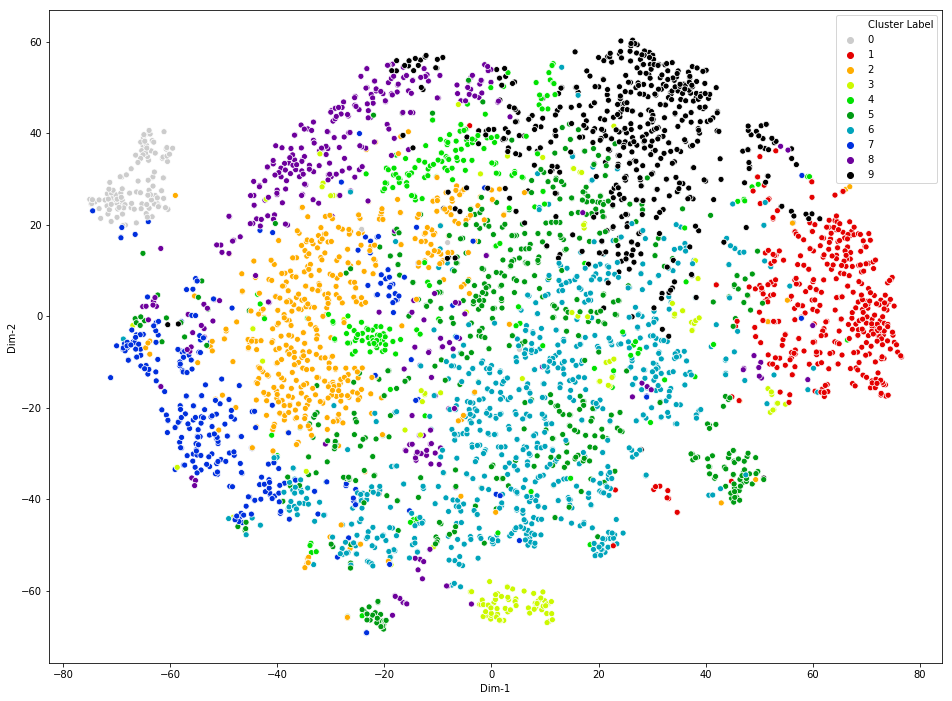

In [351]:
dfg = graph_cluster(tmatrix, dfk)

In [352]:
centroid_vec = centroid_vector(km, ftn)
top_count_vec = conv_top(corpus, dfk, stop_words)
for x,y in zip(centroid_vec.items(), top_count_vec.items()):
    print(x[0])
    print(x[1])
    print(y[1])
    print()

D:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['+', '.)', '.,', '1', '6', '7', '7park', '8', '9th', '?.', 'a100', 'a2z', 'access', 'accounting', 'acumen', 'ad', 'adcotron', 'administration', 'advanced', 'advertising', 'aegis', 'ai', 'alt', 'amazon', 'analysis', 'analytics', 'apache', 'apar', 'app', 'applications', 'applied', 'aptly', 'architects', 'artis', 'aspnet', 'associates', 'assurance', 'athgo', 'athletica', 'automation', 'ava', 'avancer', 'avenuecode', 'avt', 'b', 'banc', 'bank', 'benefits', 'bethesda', 'bevstrat', 'bgc', 'big', 'bitsoft', 'blossomy', 'boar', 'board', 'brand', 'brands', 'bridgewater', 'brillio', 'building', 'business', 'c', 'c2s', 'california', 'campaign', 'cana', 'canary', 'cancer', 'candidates', 'cannon', 'capital', 'care', 'careers', 'case', 'cash', 'cell', 'centers', 'cerebri', 'change', 'chemical', 'christus', 'clini',

0
['amazon', 'aw', 'busi', 'scienc', 'languag', '–', 'problem', 'environ', 'year', 'analysi', 'deliv', 'web', 'scientist', 'drive', 'c', 'make', 'platform', '3', 'bachelor', 'java']
['amazon', 'business', 'aws', 'services', 'learning', 'customers', 'customer', 'design', 'software', 'machine', 'solutions', 'systems', 'years', 'science', 'development', 'engineering', 'support', 'teams', 'working', 'cloud', 'analytics', 'building', 'analysis', 'degree', 'engineers', 'environment', 'scale', 'technologies', '–', 'build']

1
['client', 'busi', 'year', 'firm', 'analysi', 'environ', 'deliv', 'problem', 'creat', 'analyst', 'strategi', 'ensur', 'lead', 'make', 'offer', 'relationship', 'meet', 'media', 'member', 'scienc']
['client', 'clients', 'business', 'management', 'solutions', 'services', 'analytics', 'support', 'knowledge', 'years', 'working', 'project', 'including', 'development', 'projects', 'research', 'design', 'analysis', 'environment', 'requirements', 'information', 'engineering', 'te

From these vector outputs, we can determine the clusters are structured very well according to skills and responsibiltiies. The centroid vectors are very coherent and interpretable.

Cluster 0 - Amazon AWS Cloud Computing Platform

Cluster 1 - Business Insight and Analytics

Cluster 2 - Web developer/Software Engineer/Data Engineer

Cluster 3 - Research Analyst - Healthcare industry

Cluster 4 - Business Analyst - visualization

Cluster 5 - Marketing and Strategy  

Cluster 6 - Mix of traditional engineering, business management

Cluster 7 - Data Science/Machine Learning Engineer

Cluster 8 - Data Science/business solutions

Cluster 9 - Business analyst 

There are many different clusters that represent business related positions because there are many different business positions that have less technical skill key words that are similar. Many business positions use soft skills to describe role requirements. 

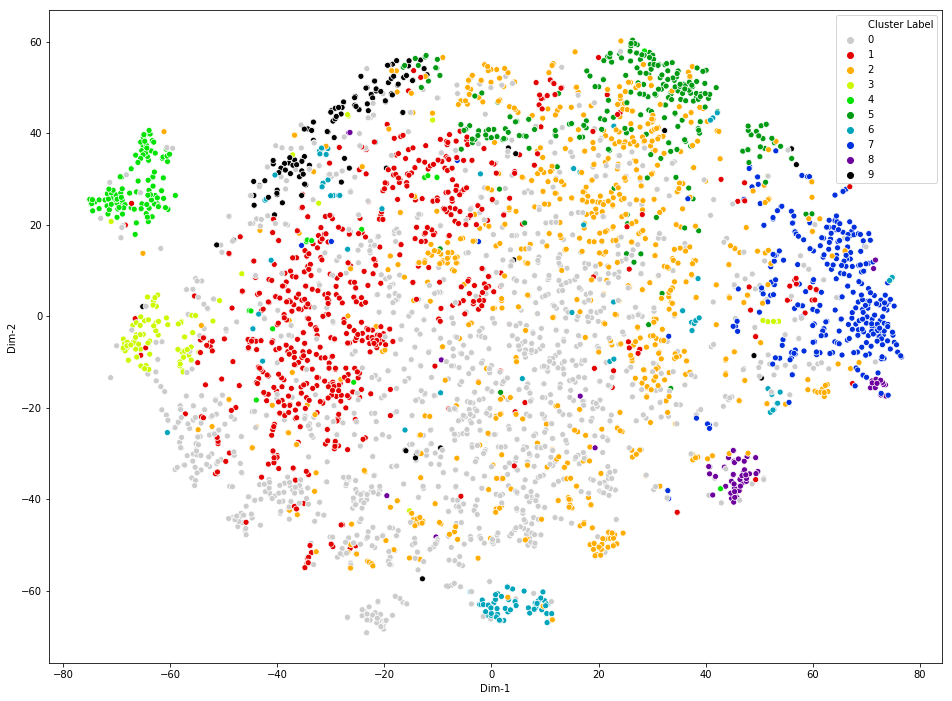

In [353]:
agc, dfw = ward(tmatrix)
dfg = graph_cluster(tmatrix, dfw)

In [354]:
top_count_vec = conv_top(corpus, dfw, stop_words)
for x in top_count_vec.items():
    print(x[0])
    print(x[1])
    print()

D:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['+', '.)', '.,', '1', '6', '7', '7park', '8', '9th', '?.', 'a100', 'a2z', 'access', 'accounting', 'acumen', 'ad', 'adcotron', 'administration', 'advanced', 'advertising', 'aegis', 'ai', 'alt', 'amazon', 'analysis', 'analytics', 'apache', 'apar', 'app', 'applications', 'applied', 'aptly', 'architects', 'artis', 'aspnet', 'associates', 'assurance', 'athgo', 'athletica', 'automation', 'ava', 'avancer', 'avenuecode', 'avt', 'b', 'banc', 'bank', 'benefits', 'bethesda', 'bevstrat', 'bgc', 'big', 'bitsoft', 'blossomy', 'boar', 'board', 'brand', 'brands', 'bridgewater', 'brillio', 'building', 'business', 'c', 'c2s', 'california', 'campaign', 'cana', 'canary', 'cancer', 'candidates', 'cannon', 'capital', 'care', 'careers', 'case', 'cash', 'cell', 'centers', 'cerebri', 'change', 'chemical', 'christus', 'clini',

0
['years', 'required', 'engineering', 'development', 'management', 'support', 'business', 'design', 'systems', 'software', 'knowledge', 'information', 'including', 'working', 'position', 'requirements', 'research', 'learning', 'analysis', 'environment', 'project', 'product', 'solutions', 'customer', 'degree', 'qualifications', 'process', 'projects', 'world', 'preferred']

1
['design', 'development', 'software', 'business', 'systems', 'years', 'knowledge', 'working', 'solutions', 'support', 'management', 'engineering', 'tools', 'services', 'product', 'technologies', 'including', 'science', 'environment', 'sql', 'database', 'build', 'applications', 'requirements', 'learning', 'using', 'platform', 'teams', 'information', 'develop']

2
['business', 'management', 'analysis', 'development', 'support', 'years', 'including', 'solutions', 'customer', 'product', 'knowledge', 'working', 'information', 'required', 'systems', 'environment', 'requirements', 'process', 'research', 'project', 'degree

Cluster 0 - Traditional Engineering

Cluster 1 -  Data Engineering (?)

Cluster 2 - Business Analyst + Traditional Engineering

Cluster 3 - Machine Learning Engineer - focus on developing ML solutions

Cluster 4 - Cloud computing Engineer - Data Engineer, Big Data

Cluster 5 - Business Analyst - visualization with PowerBI

Cluster 6 - Research Analyst, Traditional Scientist - Healthcare Industry

Cluster 8 - Marketing Analyst 

Cluster 9 - Data Scientist - focus on research and modeling 

Still somewhat interpretable, stronger than kmeans at identifying traditional engineering jobs but less effective at finding big data jobs and clusters seem more mixed together than in kmeans.

The following cells begin with developing tokenized corpuses and comparing my customized regular expression tokenizer to a default one in nltk, word punctuation tokenizer.

This step is necessary for creating w2v models.

In [355]:
#get w2vwpt
wpt2v_array = w2v_get(wpt_corpus)
kmwp2, dfkwp2 = kmeans(wpt2v_array)
# agwp2, dfagwp2 = ward(wpt2v_array)

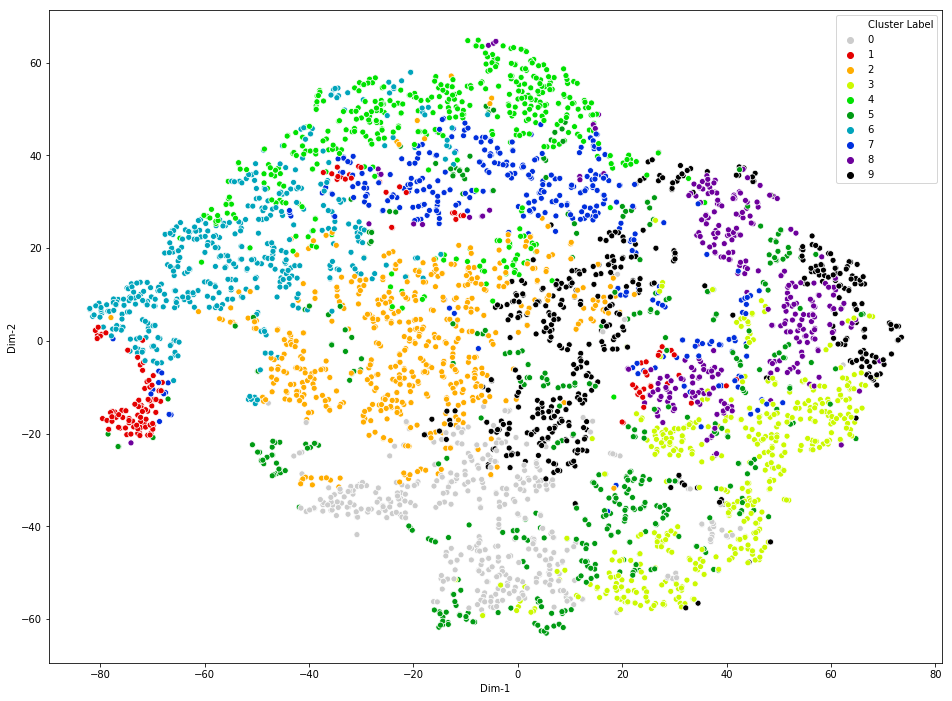

In [356]:
dfg = graph_cluster(wpt2v_array, dfkwp2)

In t-SNE 2-D space, w2v seems to create more defined clusters. There are visually more separated clusters.

In [357]:
wpt_top = conv_top(corpus, dfkwp2, stop_words)
for key, value in wpt_top.items():
    print(key)
    print(value)
    print()

D:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['+', '.)', '.,', '1', '6', '7', '7park', '8', '9th', '?.', 'a100', 'a2z', 'access', 'accounting', 'acumen', 'ad', 'adcotron', 'administration', 'advanced', 'advertising', 'aegis', 'ai', 'alt', 'amazon', 'analysis', 'analytics', 'apache', 'apar', 'app', 'applications', 'applied', 'aptly', 'architects', 'artis', 'aspnet', 'associates', 'assurance', 'athgo', 'athletica', 'automation', 'ava', 'avancer', 'avenuecode', 'avt', 'b', 'banc', 'bank', 'benefits', 'bethesda', 'bevstrat', 'bgc', 'big', 'bitsoft', 'blossomy', 'boar', 'board', 'brand', 'brands', 'bridgewater', 'brillio', 'building', 'business', 'c', 'c2s', 'california', 'campaign', 'cana', 'canary', 'cancer', 'candidates', 'cannon', 'capital', 'care', 'careers', 'case', 'cash', 'cell', 'centers', 'cerebri', 'change', 'chemical', 'christus', 'clini',

0
['business', 'product', 'world', 'learning', 'working', 'customer', 'customers', 'software', 'make', 'build', 'engineering', 'looking', 'development', 'solutions', 'design', 'building', 'years', 'teams', 'environment', 'products', 'support', 'machine', 'science', 'marketing', 'including', 'problems', 'analytics', 'systems', 'tools', '1']

1
['years', 'required', 'preferred', '1', 'year', 'development', 'business', 'software', 'knowledge', 'sql', '3', 'design', '5', 'working', 'systems', '2', 'management', '+', 'engineering', 'using', 'learning', 'science', 'java', 'programming', 'requirements', 'analysis', 'c', 'education', 'tools', 'python']

2
['business', 'management', 'support', 'including', 'customer', 'sales', 'solutions', 'development', 'environment', 'information', 'years', 'knowledge', 'working', 'process', 'project', 'analysis', 'services', 'service', 'required', 'client', 'requirements', 'clients', 'position', 'projects', 'product', 'world', 'communication', 'ensure', 'cus

Too many clusters business related, unable to find data engineering, 

In [358]:
#get w2vgg
gg_array = w2v_get(gg_corpus)
kmgg, dfkgg = kmeans(gg_array)

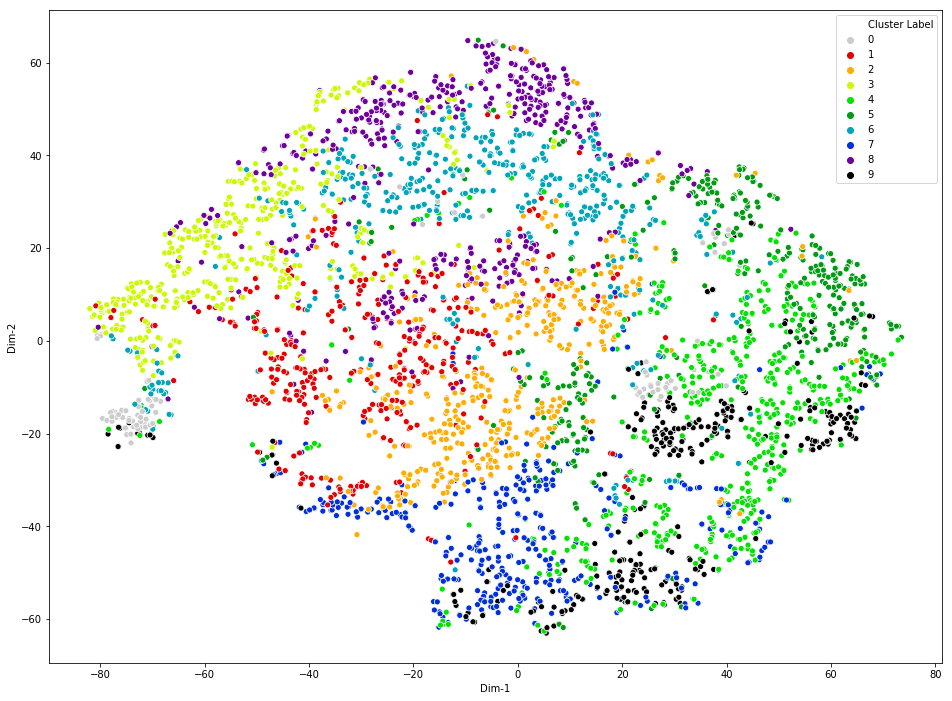

In [359]:
dfg = graph_cluster(wpt2v_array, dfkgg)

In [360]:
wpt_top = conv_top(corpus, dfkgg, stop_words)
for key, value in wpt_top.items():
    print(key)
    print(value)
    print()

D:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['+', '.)', '.,', '1', '6', '7', '7park', '8', '9th', '?.', 'a100', 'a2z', 'access', 'accounting', 'acumen', 'ad', 'adcotron', 'administration', 'advanced', 'advertising', 'aegis', 'ai', 'alt', 'amazon', 'analysis', 'analytics', 'apache', 'apar', 'app', 'applications', 'applied', 'aptly', 'architects', 'artis', 'aspnet', 'associates', 'assurance', 'athgo', 'athletica', 'automation', 'ava', 'avancer', 'avenuecode', 'avt', 'b', 'banc', 'bank', 'benefits', 'bethesda', 'bevstrat', 'bgc', 'big', 'bitsoft', 'blossomy', 'boar', 'board', 'brand', 'brands', 'bridgewater', 'brillio', 'building', 'business', 'c', 'c2s', 'california', 'campaign', 'cana', 'canary', 'cancer', 'candidates', 'cannon', 'capital', 'care', 'careers', 'case', 'cash', 'cell', 'centers', 'cerebri', 'change', 'chemical', 'christus', 'clini',

0
['years', 'sql', 'preferred', 'required', 'development', '1', 'business', 'design', 'knowledge', 'year', 'tools', '+', 'working', 'hadoop', 'etl', 'python', '2', '5', 'java', 'software', '3', 'science', 'using', 'understanding', 'database', 'requirements', 'strong', 'spark', 'systems', 'server']

1
['business', 'support', 'management', 'environment', 'customer', 'required', 'knowledge', 'information', 'years', 'service', 'including', 'working', 'position', 'customers', 'research', 'services', 'process', 'world', 'development', 'communication', 'clients', 'employees', 'benefits', 'solutions', 'projects', 'sales', 'analysis', 'client', 'degree', 'project']

2
['business', 'management', 'marketing', 'customer', 'product', 'solutions', 'sales', 'support', 'development', 'teams', 'including', 'working', 'analytics', 'years', 'client', 'clients', 'customers', 'environment', 'develop', 'services', 'analysis', 'world', 'strategy', 'knowledge', 'products', 'opportunities', 'performance', 'req

Cluster 0 - Data Engineer

Cluster 1 - Business Analyst 

Cluster 2 - Business Analyst - focus on marketing and sales

Cluster 3 - Research Analyst - 

Cluster 4 - Software Engineer, focus on cloud compputing 

Cluster 5 - Data Analyst - business, modeling, database knowledge

Cluster 6 - Software Engineer, Web testing, A/B, security, 

Cluster 7 - Traditional Engineering 

Cluster 8 - Business analyst - reporting visualization

Cluster 9 - Machine Learning, Data Science

In [361]:
lad,label_df, group_df, vis,vtsne = lda_get(gg_corpus)

D:\Anaconda\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
D:\Anaconda\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [362]:
lad.print_topics()

[(0,
  '0.062*"manag" + 0.054*"project" + 0.047*"busi" + 0.037*"develop" + 0.035*"process" + 0.024*"plan" + 0.021*"improv" + 0.017*"ensur" + 0.016*"execut" + 0.016*"oper"'),
 (1,
  '0.067*"invest" + 0.057*"risk" + 0.051*"asset" + 0.040*"bank" + 0.028*"manag" + 0.027*"capit" + 0.027*"financ" + 0.026*"build" + 0.024*"payment" + 0.024*"equiti"'),
 (2,
  '0.047*"requir" + 0.035*"report" + 0.024*"year" + 0.018*"prefer" + 0.017*"duti" + 0.015*"schedul" + 0.014*"manag" + 0.014*"maintain" + 0.014*"perform" + 0.014*"project"'),
 (3,
  '0.072*"busi" + 0.063*"solut" + 0.036*"develop" + 0.032*"secur" + 0.029*"enterpris" + 0.020*"design" + 0.020*"lead" + 0.018*"architectur" + 0.017*"implement" + 0.017*"technolog"'),
 (4,
  '0.087*"develop" + 0.070*"softwar" + 0.043*"design" + 0.038*"code" + 0.026*"web" + 0.023*"year" + 0.021*"applic" + 0.021*"c" + 0.019*"java" + 0.019*"engin"'),
 (5,
  '0.022*"make" + 0.017*"world" + 0.016*"look" + 0.015*"work" + 0.014*"grow" + 0.013*"learn" + 0.013*"build" + 0.013

Topic 0 - Manage projects, business, supply chain

Topic 1 - Finance, banking

Topic 2 - Inventory management, 

Topic 3 - Business technology, architect

Topic 4 - Software Development, web applications

Topic 5 - Generic buzz words

Topic 6 - Software testing (?)

Topic 7 - Machine Learning, Data science

Topic 8 - Equal opportunity employer information

Topic 9 - Healthcare industry

Topic 10 - Systems engineer?

Topic 11 - Sales and Marketing

Topic 12 - Business solutions

Topic 13 - Consulting

Topic 14 - Cloud computing, big data, database engineer

Topic 15 - Traditional engineering

Topic 16 - Business analyst, insight, database

Topic 17 - Data engineer

Topic 18 - Marketing

Topic 19 - Traditional scientist 


In [370]:
print(label_df['Cluster Label'].value_counts())

5.0     809
2.0     493
12.0    364
0.0     272
7.0     244
16.0    239
17.0    200
14.0    196
10.0    165
18.0    156
4.0     138
3.0     131
19.0     93
8.0      81
6.0      60
9.0      51
13.0     38
1.0      37
15.0     26
11.0     19
Name: Cluster Label, dtype: int64


In [371]:
label_df.head(10)

,Cluster Label,Perc_Contribution,Topic_Keywords,Tokenized Text
0,12.0,0.3106,"support, manag, system, knowledg, servic, issu...","[busi, intellig, analyst, go, project, focus, ..."
1,2.0,0.3613,"requir, report, year, prefer, duti, schedul, m...","[equip, problem, perform, includ, problem, par..."
2,2.0,0.3968,"requir, report, year, prefer, duti, schedul, m...","[entri, level, engin, posit, parti, test, grow..."
3,7.0,0.2358,"learn, machin, model, scienc, scientist, probl...","[generat, mobil, servic, world, mobil, demand,..."
4,5.0,0.4111,"make, world, look, work, grow, learn, build, e...","[languag, work, establish, ai, startup, pre, g..."
5,5.0,0.2386,"make, world, look, work, grow, learn, build, e...","[set, world, problem, driver, deliveri, partne..."
6,5.0,0.4976,"make, world, look, work, grow, learn, build, e...","[client, servic, champion, deliv, market, chan..."
7,2.0,0.3484,"requir, report, year, prefer, duti, schedul, m...","[school, year, school, thousand, scientist, sh..."
8,7.0,0.1957,"learn, machin, model, scienc, scientist, probl...","[financi, servic, bring, transform, credit, cr..."
9,5.0,0.3370,"make, world, look, work, grow, learn, build, e...","[look, scientist, focus, recommend, join, scie..."


In [405]:
group_df.drop('Subset_Index', axis=1, inplace=True)
group_df.head(20)


,Cluster Label,Perc_Contribution,Topic_Keywords,Tokenized Text
86,0.0,0.7146,"manag, project, busi, develop, process, plan, ...","[plan, schedul, coordin, demand, suppli, manag..."
1687,1.0,0.4749,"invest, risk, asset, bank, manag, capit, finan...","[member, softwar, engin, group, look, solv, bu..."
3388,2.0,0.7369,"requir, report, year, prefer, duti, schedul, m...","[descript, inventori, e, custom, report, proce..."
387,3.0,0.4715,"busi, solut, develop, secur, enterpris, design...","[make, world, class, entertain, leader, passio..."
2893,4.0,0.6771,"develop, softwar, design, code, web, year, app...","[respons, design, develop, document, improv, m..."
809,5.0,0.7646,"make, world, look, work, grow, learn, build, e...","[look, day, motiv, person, look, cultur, excel..."
1586,6.0,0.4902,"test, requir, develop, qualiti, document, desi...","[look, test, script, duti, design, implement, ..."
1051,7.0,0.5961,"learn, machin, model, scienc, scientist, probl...","[look, senior, nlp, scientist, join, scienc, s..."
2979,8.0,0.8115,"inform, applic, posit, requir, e, accommod, re...","[commit, provid, accommod, applic, appli, need..."
2938,9.0,0.5019,"program, educ, healthcar, care, univers, patie...","[inform, system, analyst, appli, advanc, infor..."


In [408]:
df_merge = pd.merge(dfs, group_df, left_on='Subset_Index', right_index=True, how='inner')
df_merge.head(20)

,Job Title,Company,Location,Description,Subset_Index,Cluster Label,Perc_Contribution,Topic_Keywords,Tokenized Text
21870,Strategic Procurement Business analyst,Hewlett Packard Enterprise,"Houston, TX 77070","Responsible for planning, scheduling and coord...",86,0.0,0.7146,"manag, project, busi, develop, process, plan, ...","[plan, schedul, coordin, demand, suppli, manag..."
20087,Architect,The Walt Disney Company (Corporate),"Burbank, CA","At Disney, we’re storytellers. We make the imp...",387,3.0,0.4715,"busi, solut, develop, secur, enterpris, design...","[make, world, class, entertain, leader, passio..."
1487,Sales Representative (Koodo),TELUS Communications,"Etobicoke, ON",Are you looking for each day to be different?\...,809,5.0,0.7646,"make, world, look, work, grow, learn, build, e...","[look, day, motiv, person, look, cultur, excel..."
10958,Senior ML Engineer,AnswerIQ,"Bellevue, WA",AnswerIQ is looking for a Senior Data/NLP Scie...,1051,7.0,0.5961,"learn, machin, model, scienc, scientist, probl...","[look, senior, nlp, scientist, join, scienc, s..."
12569,Entry Level Analog Design Engineer,Cirrus Logic,"Austin, TX 78746",Join a team of mixed-signal designers to devel...,1185,10.0,0.5891,"engin, design, system, develop, softwar, hardw...","[join, design, develop, generat, applic, parti..."
4142,Software Engineer I,"Amazon Web Services, Inc.","Seattle, WA",Bachelor's degree in Computer Science or relat...,1424,14.0,0.5803,"engin, build, platform, scale, softwar, servic...","[bachelor, degre, scienc, relat, 5, year, scie..."
419,VuGen testing and Scripting (LoadRunner),Progression3,"Toronto, ON",We are looking for Testing SME with strong VuG...,1586,6.0,0.4902,"test, requir, develop, qualiti, document, desi...","[look, test, script, duti, design, implement, ..."
10836,ETL/Data Architect,United Consulting LLC,"Santa Clara, CA",Experience Required- 10+ years of experience i...,1603,17.0,0.7651,"databas, year, sql, spark, etl, design, develo...","[requir, 10, year, analyt, model, design, etl,..."
15829,Java Full Stack DevOps Software Engineer,JP Morgan Chase,"Westerville, OH 43081",As a member of our Software Engineering Group ...,1687,1.0,0.4749,"invest, risk, asset, bank, manag, capit, finan...","[member, softwar, engin, group, look, solv, bu..."
17499,"Brand Marketing Manager, abercrombie kids",Abercrombie and Fitch Co.,"Columbus, OH",Job Description\n\nOur Marketing team has the ...,1997,18.0,0.5706,"market, strategi, busi, brand, team, partner, ...","[descript, market, respons, custom, evolv, bra..."


In [365]:
pyLDAvis.save_html(vis, 'lda.html')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.094714 -0.153159       1        1  14.239113
12     0.077388  0.066691       2        1  10.134358
2      0.151333  0.175718       3        1  10.052839
0      0.122816  0.061098       4        1   8.732610
16    -0.045989  0.175496       5        1   5.801600
8      0.149546  0.089507       6        1   5.379834
14    -0.183335 -0.168243       7        1   5.246463
18     0.088546 -0.013626       8        1   4.728386
3      0.016199  0.009102       9        1   4.578993
10    -0.146754  0.045246      10        1   4.060887
7     -0.179227  0.042259      11        1   4.038353
17    -0.217343  0.083317      12        1   3.517658
4     -0.243464  0.053804      13        1   3.245706
9      0.144894  0.069222      14        1   3.178804
6     -0.089128  0.093644      15        1   2.782727
19     0.016071  0.144756      16        1   2.663954
13     0.182781 -0.053605      17        1   2.352502
15    -0.133572 -0.267605      18        1   2.035573
11     0.121980 -0.232183      19        1   1.807019
1      0.072542 -0.221441      20        1   1.422618, topic_info=    Category          Freq       Term         Total  loglift  logprob
31   Default   6653.000000     custom   6653.000000  30.0000  30.0000
109  Default   7536.000000    product   7536.000000  29.0000  29.0000
185  Default   8361.000000      engin   8361.000000  28.0000  28.0000
20   Default   3408.000000     client   3408.000000  27.0000  27.0000
231  Default   3802.000000   research   3802.000000  26.0000  26.0000
16   Default  10904.000000       busi  10904.000000  25.0000  25.0000
144  Default   3399.000000       test   3399.000000  24.0000  24.0000
203  Default   4842.000000      learn   4842.000000  23.0000  23.0000
111  Default   6855.000000    project   6855.000000  22.0000  22.0000
39   Default  11833.000000    develop  11833.000000  21.0000  21.0000
83   Default   9942.000000      manag   9942.000000  20.0000  20.0000
117  Default   9451.000000     requir   9451.000000  19.0000  19.0000
37   Default   6317.000000     design   6317.000000  18.0000  18.0000
84   Default   3349.000000     market   3349.000000  17.0000  17.0000
115  Default   4741.000000     report   4741.000000  16.0000  16.0000
269  Default   5060.000000      build   5060.000000  15.0000  15.0000
130  Default   4369.000000    softwar   4369.000000  14.0000  14.0000
121  Default   1842.000000       sale   1842.000000  13.0000  13.0000
293  Default   2734.000000     machin   2734.000000  12.0000  12.0000
131  Default   5134.000000      solut   5134.000000  11.0000  11.0000
127  Default   5160.000000     servic   5160.000000  10.0000  10.0000
295  Default   3223.000000      model   3223.000000   9.0000   9.0000
140  Default   6845.000000    support   6845.000000   8.0000   8.0000
5    Default   4159.000000    analysi   4159.000000   7.0000   7.0000
108  Default   6145.000000    process   6145.000000   6.0000   6.0000
7    Default   2961.000000     analyt   2961.000000   5.0000   5.0000
313  Default   3140.000000      world   3140.000000   4.0000   4.0000
110  Default   4148.000000    program   4148.000000   3.0000   3.0000
141  Default   4353.000000     system   4353.000000   2.0000   2.0000
123  Default   3654.000000     scienc   3654.000000   1.0000   1.0000
..       ...           ...        ...           ...      ...      ...
459  Topic20    584.444641       risk   1172.855225   3.5561  -2.8711
412  Topic20     34.541073       auto     76.826324   3.4533  -5.6996
569  Topic20    179.937729  portfolio    431.748932   3.3774  -4.0492
810  Topic20     60.923435      tackl    177.563812   3.1830  -5.1322
670  Topic20     55.253933   strength    163.151581   3.1699  -5.2298
713  Topic20    277.285828     financ    828.327576   3.1583  -3.6167
700  Topic20     46.425327    thought    151.631683   3.0691  -5.4039
893  Topic20     34.910515   landscap  

In [366]:
vtsne #note crossover between documents with specific topics, 

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
5     -121.734161   23.470116       1        1  14.239466
12      51.459785  -15.746586       2        1  10.134356
2      118.501534  -32.343037       3        1  10.052454
0     -104.203331   92.175224       4        1   8.732734
16       1.464445  -54.263168       5        1   5.802547
8      -53.471203  140.000214       6        1   5.379732
14    -122.262238  -49.953526       7        1   5.245738
18     111.950737  109.438683       8        1   4.728559
3       18.553125  155.894211       9        1   4.577490
10     -10.184723    3.559841      10        1   4.060638
7        9.915181 -119.635460      11        1   4.038847
17      48.760284   99.541634      12        1   3.517947
4      -16.184229   86.861214      13        1   3.246868
9      -58.657970  -91.125801      14        1   3.179287
6       25.002432   44.283772      15        1   2.782339
19     -62.512093  -21.977957      16        1   2.663672
13      71.384094  -82.317032      17        1   2.352541
15     -56.612663   43.139378      18        1   2.034656
11      83.167183   38.184025      19        1   1.806817
1      145.754837   36.647255      20        1   1.423308, topic_info=    Category          Freq       Term         Total  loglift  logprob
31   Default   6653.000000     custom   6653.000000  30.0000  30.0000
109  Default   7534.000000    product   7534.000000  29.0000  29.0000
185  Default   8361.000000      engin   8361.000000  28.0000  28.0000
20   Default   3408.000000     client   3408.000000  27.0000  27.0000
231  Default   3802.000000   research   3802.000000  26.0000  26.0000
16   Default  10904.000000       busi  10904.000000  25.0000  25.0000
144  Default   3398.000000       test   3398.000000  24.0000  24.0000
203  Default   4843.000000      learn   4843.000000  23.0000  23.0000
111  Default   6855.000000    project   6855.000000  22.0000  22.0000
39   Default  11833.000000    develop  11833.000000  21.0000  21.0000
83   Default   9942.000000      manag   9942.000000  20.0000  20.0000
117  Default   9451.000000     requir   9451.000000  19.0000  19.0000
37   Default   6317.000000     design   6317.000000  18.0000  18.0000
84   Default   3349.000000     market   3349.000000  17.0000  17.0000
115  Default   4741.000000     report   4741.000000  16.0000  16.0000
269  Default   5060.000000      build   5060.000000  15.0000  15.0000
130  Default   4369.000000    softwar   4369.000000  14.0000  14.0000
121  Default   1842.000000       sale   1842.000000  13.0000  13.0000
293  Default   2734.000000     machin   2734.000000  12.0000  12.0000
131  Default   5133.000000      solut   5133.000000  11.0000  11.0000
127  Default   5160.000000     servic   5160.000000  10.0000  10.0000
295  Default   3224.000000      model   3224.000000   9.0000   9.0000
140  Default   6845.000000    support   6845.000000   8.0000   8.0000
5    Default   4160.000000    analysi   4160.000000   7.0000   7.0000
108  Default   6145.000000    process   6145.000000   6.0000   6.0000
7    Default   2961.000000     analyt   2961.000000   5.0000   5.0000
313  Default   3140.000000      world   3140.000000   4.0000   4.0000
110  Default   4149.000000    program   4149.000000   3.0000   3.0000
141  Default   4353.000000     system   4353.000000   2.0000   2.0000
123  Default   3654.000000     scienc   3654.000000   1.0000   1.0000
..       ...           ...        ...           ...      ...      ...
459  Topic20    584.728271       risk   1173.044556   3.5560  -2.8711
412  Topic20     34.557835       auto     76.843063   3.4531  -5.6996
569  Topic20    180.025055  portfolio    431.826660   3.3773  -4.0492
810  Topic20     60.953003      tackl    177.599289   3.1828  -5.1322
670  Topic20     55.280746   strength    163.181610   3.1697  -5.2298
713  Topic20    277.420380     financ    828.469971   3.1581  -3.6167
700  Topic20     46.4

In [ ]:
dfg = graph_cluster(tmatrix, label_df)

In [ ]:
dfg = graph_cluster(wpt2v_array, label_df)

In [236]:
lads,viss,vtsnes = lda_get(ggt_corpus, num_topics=12)

D:\Anaconda\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
D:\Anaconda\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [237]:
lads.print_topics()

[(0,
  '0.222*"www" + 0.122*"fun" + 0.110*"vehicl" + 0.099*"driver" + 0.075*"exampl" + 0.066*"https" + 0.064*"internet" + 0.052*"ci" + 0.043*"saa" + 0.042*"cd"'),
 (1,
  '0.947*"client" + 0.042*"sr" + 0.005*"regardless" + 0.000*"unformattedesqa508c" + 0.000*"transp" + 0.000*"arti" + 0.000*"�" + 0.000*"ucavgapyifctulmntag" + 0.000*"ie691343" + 0.000*"yl6qlbiea"'),
 (2,
  '0.331*"ml" + 0.200*"azur" + 0.191*"hardwar" + 0.146*"devic" + 0.064*"tensorflow" + 0.035*"iot" + 0.025*"c" + 0.000*"ddtc" + 0.000*"prescribednondiscriminationpostinglanguag" + 0.000*"eo13665"'),
 (3,
  '0.113*"healthcar" + 0.094*"”" + 0.093*"facil" + 0.087*"patient" + 0.079*"“" + 0.078*"eeo" + 0.069*"specialist" + 0.066*"personnel" + 0.065*"statement" + 0.054*"student"'),
 (4,
  '0.245*"scienc" + 0.126*"languag" + 0.122*"python" + 0.098*"scientist" + 0.066*"r" + 0.057*"problem" + 0.048*"c" + 0.035*"hadoop" + 0.029*"big" + 0.028*"java"'),
 (5,
  '0.279*"year" + 0.079*"2" + 0.075*"3" + 0.069*"5" + 0.067*"1" + 0.052*"bach

In [238]:
# pyLDAvis.save_html(viss, 'ldax.html')
viss

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.222530  0.111695       1        1  44.095768
5      0.221525  0.213122       2        1  15.624504
9      0.229786 -0.034239       3        1  11.318004
4      0.075149 -0.293998       4        1   9.394995
6      0.011552 -0.106169       5        1   5.014735
3      0.015681  0.176872       6        1   3.678012
1     -0.172737  0.052584       7        1   2.545779
0     -0.167196  0.043127       8        1   2.184072
8      0.050292 -0.259290       9        1   2.047753
7     -0.164404  0.092817      10        1   1.601497
2     -0.172480 -0.064140      11        1   1.540107
10    -0.149698  0.067620      12        1   0.954768, topic_info=    Category          Freq                                               Term  \
10   Default   3526.000000                                             client   
39   Default   6371.000000                                               year   
1    Default   4009.000000                                            analysi   
8    Default  10044.000000                                               busi   
32   Default   3374.000000                                             scienc   
128  Default   1151.000000                                              asset   
35   Default   1912.000000                                                sql   
48   Default   1734.000000                                            languag   
53   Default   1681.000000                                             python   
66   Default   1709.000000                                                  e   
98   Default    937.000000                                                 aw   
41   Default   1807.000000                                                  2   
28   Default   3861.000000                                            problem   
29   Default   2393.000000                                             qualif   
33   Default   1352.000000                                          scientist   
64   Default   1713.000000                                                  3   
203  Default    746.000000                                                 ml   
0    Default   1583.000000                                                  5   
79   Default   1529.000000                                                  1   
21   Default   3423.000000                                               make   
61   Default    709.000000                                                www   
60   Default    881.000000                                                web   
194  Default    513.000000                                             energi   
59   Default   1382.000000                                               user   
118  Default    547.000000                                              event   
12   Default   2813.000000                                              creat   
149  Default    828.000000                                          framework   
72   Default   1597.000000                                           bachelor   
19   Default   2718.000000                                               lead   
30   Default   1010.000000                                                  r   
..       ...           ...                                                ...   
225  Topic12      0.084327                                            schmerk   
222  Topic12      0.084327                                                 uu   
221  Topic12      0.084327                                           q6rrzj7u   
229  Topic12      0.084327                                                ️❤️   
234  Topic12      0.084327                                              votcq   
233  Topic12      0.084327                       plu6w86lchii5lgzcbu8if8nc35u   
232  Topic12      0.084327                                           mstarinc   
240  Topic12      0.084327                

In [44]:
ss, sil, sil_samp = elbow(tmatrix, range(5,30,1))

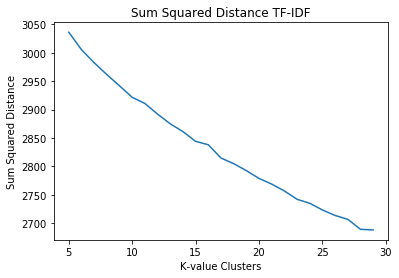

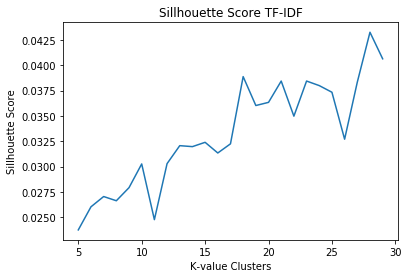

In [71]:
#5 - 30, 
plt.plot(range(5,30,1),ss)
plt.title('Sum Squared Distance TF-IDF')
plt.ylabel('Sum Squared Distance')
plt.xlabel('K-value Clusters')
plt.show()
plt.plot(range(5,30,1),sil)
plt.title('Sillhouette Score TF-IDF')
plt.ylabel('Sillhouette Score')
plt.xlabel('K-value Clusters')
plt.show()

# optimal at 10, 18 -> try 18

In [54]:
ss10, sil10, sil_samp10 = elbow(tmatrix, range(10,100,5))

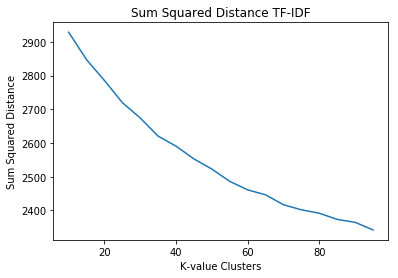

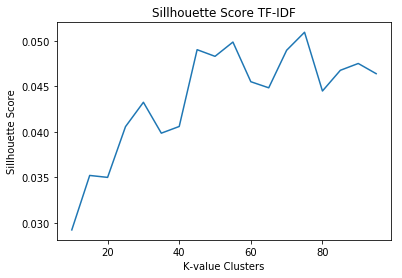

In [72]:
#10 -100, observe longer term trend
plt.plot(range(10,100,5),ss10)
plt.title('Sum Squared Distance TF-IDF')
plt.ylabel('Sum Squared Distance')
plt.xlabel('K-value Clusters')
plt.show()
plt.plot(range(10,100,5),sil10)
plt.title('Sillhouette Score TF-IDF')
plt.ylabel('Sillhouette Score')
plt.xlabel('K-value Clusters')
plt.show()
#continuous improvement, may not be interpretable at such high number of clusters

In [58]:
sswp, silwp, sil_sampwp = elbow(wpt2v_array, range(5,30,1))
ssgg, silgg, sil_sampgg = elbow(gg_array, range(5,30,1))


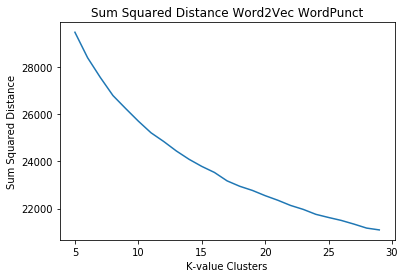

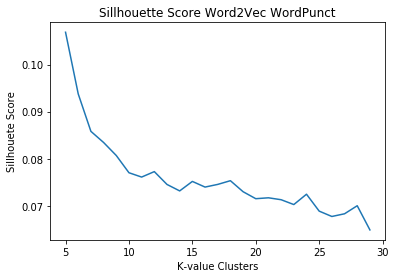

In [74]:
plt.plot(range(5,30,1),sswp)
plt.title('Sum Squared Distance Word2Vec WordPunct')
plt.ylabel('Sum Squared Distance')
plt.xlabel('K-value Clusters')
plt.show()
plt.plot(range(5,30,1),silwp)
plt.title('Sillhouette Score Word2Vec WordPunct')
plt.ylabel('Sillhouete Score')
plt.xlabel('K-value Clusters')
plt.show()
#optimal around 10 and 17

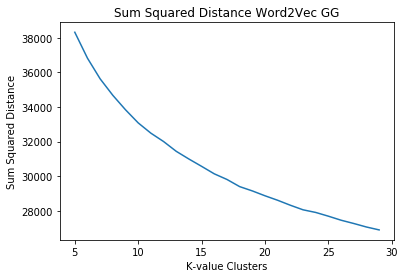

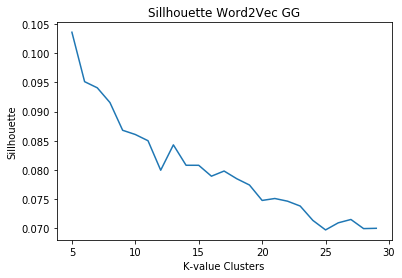

In [75]:
plt.plot(range(5,30,1),ssgg)
plt.title('Sum Squared Distance Word2Vec GG')
plt.ylabel('Sum Squared Distance')
plt.xlabel('K-value Clusters')
plt.show()
plt.plot(range(5,30,1),silgg)
plt.title('Sillhouette Word2Vec GG')
plt.ylabel('Sillhouette')
plt.xlabel('K-value Clusters')
plt.show()
#13 and 17

In [78]:
perp_list, coh_list = lda_opt(gg_corpus, range(10,50,5))   

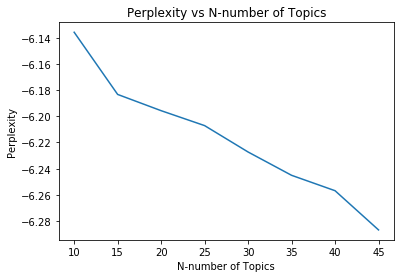

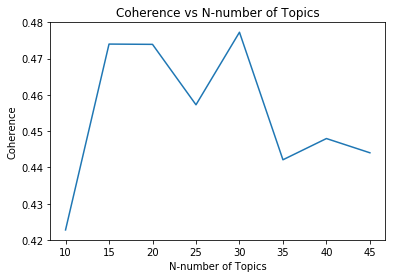

In [79]:
plt.plot(range(10,50,5),perp_list)
plt.title('Perplexity vs N-number of Topics')
plt.ylabel('Perplexity')
plt.xlabel('N-number of Topics')
plt.show()
plt.plot(range(10,50,5),coh_list)
plt.title('Coherence vs N-number of Topics')
plt.ylabel('Coherence')
plt.xlabel('N-number of Topics')
plt.show()

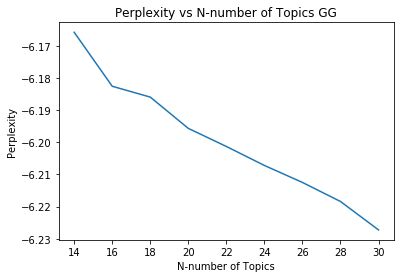

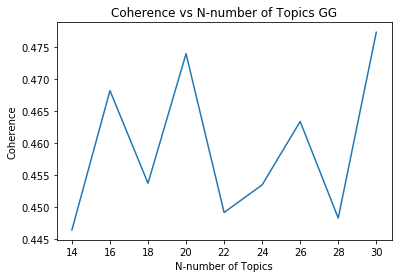

In [77]:
perp_list, coh_list = lda_opt(gg_corpus, range(14,32,2))   
plt.plot(range(14,32,2),perp_list)
plt.title('Perplexity vs N-number of Topics GG')
plt.ylabel('Perplexity')
plt.xlabel('N-number of Topics')
plt.show()
plt.plot(range(14,32,2),coh_list)
plt.title('Coherence vs N-number of Topics GG')
plt.ylabel('Coherence')
plt.xlabel('N-number of Topics')
plt.show()
# 20 good number of topics, peak coherence and kink in perplexity

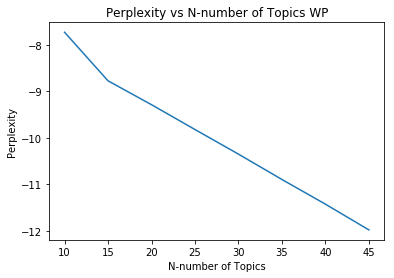

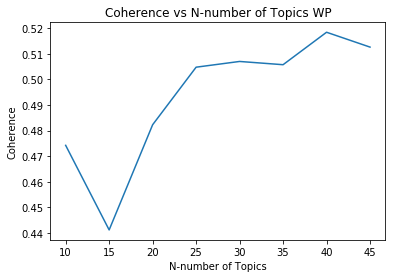

In [80]:
perp_listwp, coh_listwp = lda_opt(wpt_corpus, range(10,50,5))   
plt.plot(range(10,50,5),perp_listwp)
plt.title('Perplexity vs N-number of Topics WP')
plt.ylabel('Perplexity')
plt.xlabel('N-number of Topics')
plt.show()
plt.plot(range(10,50,5),coh_listwp)
plt.title('Coherence vs N-number of Topics WP')
plt.ylabel('Coherence')
plt.xlabel('N-number of Topics')
plt.show()

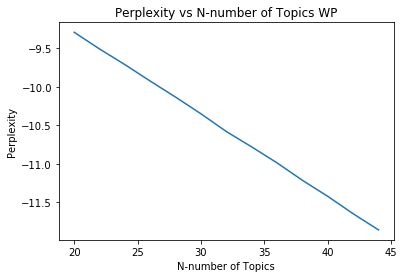

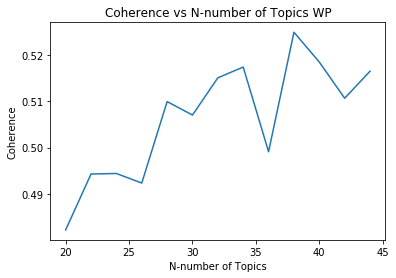

In [81]:
perp_listwpl, coh_listwpl = lda_opt(wpt_corpus, range(20,45,2))   
plt.plot(range(20,45,2),perp_listwpl)
plt.title('Perplexity vs N-number of Topics WP')
plt.ylabel('Perplexity')
plt.xlabel('N-number of Topics')
plt.show()
plt.plot(range(20,45,2),coh_listwpl)
plt.title('Coherence vs N-number of Topics WP')
plt.ylabel('Coherence')
plt.xlabel('N-number of Topics')
plt.show()

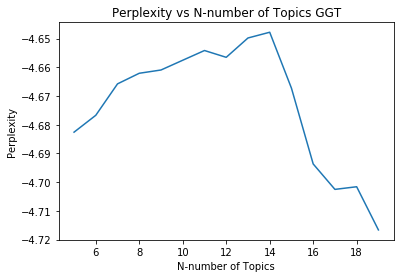

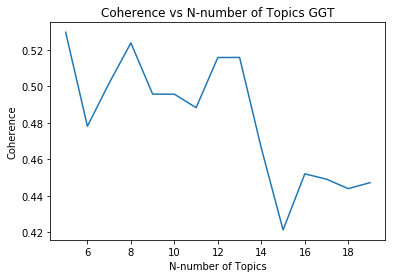

In [235]:
perp_listwpl, coh_listwpl = lda_opt(ggt_corpus, range(5,20,1))   
plt.plot(range(5,20,1),perp_listwpl)
plt.title('Perplexity vs N-number of Topics GGT')
plt.ylabel('Perplexity')
plt.xlabel('N-number of Topics')
plt.show()
plt.plot(range(5,20,1),coh_listwpl)
plt.title('Coherence vs N-number of Topics GGT')
plt.ylabel('Coherence')
plt.xlabel('N-number of Topics')
plt.show()

In [82]:
lad28,vis28,vtsne28 = lda_get(wpt_corpus, num_topics=28)

D:\Anaconda\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
D:\Anaconda\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [84]:
lad28.print_topics()

[(21,
  '0.000*"Static" + 0.000*"Threads" + 0.000*"Merch" + 0.000*"Precima" + 0.000*"diplomatic" + 0.000*"reco" + 0.000*"Listing" + 0.000*"emphasizing" + 0.000*"disaggregate" + 0.000*"sights"'),
 (8,
  '0.000*"Static" + 0.000*"Threads" + 0.000*"Merch" + 0.000*"Precima" + 0.000*"diplomatic" + 0.000*"reco" + 0.000*"Listing" + 0.000*"emphasizing" + 0.000*"disaggregate" + 0.000*"sights"'),
 (3,
  '0.000*"Static" + 0.000*"Threads" + 0.000*"Merch" + 0.000*"Precima" + 0.000*"diplomatic" + 0.000*"reco" + 0.000*"Listing" + 0.000*"emphasizing" + 0.000*"disaggregate" + 0.000*"sights"'),
 (25,
  '0.000*"Static" + 0.000*"Threads" + 0.000*"Merch" + 0.000*"Precima" + 0.000*"diplomatic" + 0.000*"reco" + 0.000*"Listing" + 0.000*"emphasizing" + 0.000*"disaggregate" + 0.000*"sights"'),
 (6,
  '0.000*"Static" + 0.000*"Threads" + 0.000*"Merch" + 0.000*"Precima" + 0.000*"diplomatic" + 0.000*"reco" + 0.000*"Listing" + 0.000*"emphasizing" + 0.000*"disaggregate" + 0.000*"sights"'),
 (17,
  '0.000*"Static" + 0.

In [420]:
lad38, vis38,vtsne38 = lda_get(wpt_corpus, num_topics=38)

D:\Anaconda\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
D:\Anaconda\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


ValueError: too many values to unpack (expected 3)

In [ ]:
lad38.print_topics()

In [ ]:
ladm, label_mdf, topm_doc = lda_mallet_get(gg_corpus, num_topics=20)

In [374]:
ladm.print_topics()

[(0,
  '0.051*"lead" + 0.042*"team" + 0.034*"drive" + 0.034*"improv" + 0.029*"leadership" + 0.027*"organ" + 0.025*"collabor" + 0.023*"level" + 0.023*"partner" + 0.023*"strategi"'),
 (1,
  '0.118*"research" + 0.053*"develop" + 0.040*"analysi" + 0.023*"scienc" + 0.022*"healthcar" + 0.021*"program" + 0.021*"care" + 0.020*"studi" + 0.019*"demonstr" + 0.016*"candid"'),
 (2,
  '0.076*"requir" + 0.028*"duti" + 0.027*"posit" + 0.025*"equip" + 0.024*"respons" + 0.021*"oper" + 0.021*"level" + 0.021*"perform" + 0.017*"schedul" + 0.017*"knowledg"'),
 (3,
  '0.179*"custom" + 0.104*"client" + 0.081*"servic" + 0.041*"solut" + 0.027*"–" + 0.025*"consult" + 0.024*"deliv" + 0.017*"focus" + 0.013*"provid" + 0.013*"base"'),
 (4,
  '0.083*"busi" + 0.082*"analyt" + 0.054*"analysi" + 0.044*"insight" + 0.034*"report" + 0.029*"decis" + 0.026*"analyst" + 0.024*"tool" + 0.021*"model" + 0.021*"visual"'),
 (5,
  '0.169*"project" + 0.162*"manag" + 0.051*"plan" + 0.048*"support" + 0.046*"develop" + 0.032*"process" +

LDA mallet implementation seems to perform quite well. The topics seem slightly more interpretable. 

Topic 0 - Leadershi, manage teams

Topic 1 - Healthcare Research Analyst/Traditional Scientist

Topic 2 - Soft skills, duty,equip, operate, schedule

Topic 3 - Consulting 

Topic 4 - Business Analyst, Reporting, visualiations

Topic 5 - Project management

Topic 6 - Machine learning, Data Science

Topic 7 - General application information 

Topic 8 - Finanace, banking, risk management

Topic 9 - Marketing Analyst

Topic 10 - Business management

Topic 11 - Data analyst, finance, reporting

Topic 12 - General application information, eeo 

Topic 13 - Traditional engineering, QA, Systems, process

Topic 14 - Cloud computing, AWS, software engineering

Topic 15 - Degree requirements, experience years 

Topic 16 - Systems support, IT?

Topic 17 - Reporting analyst

Topic 18 - Data engineer, database developer

Topic 19 - Generic buzz words about culture


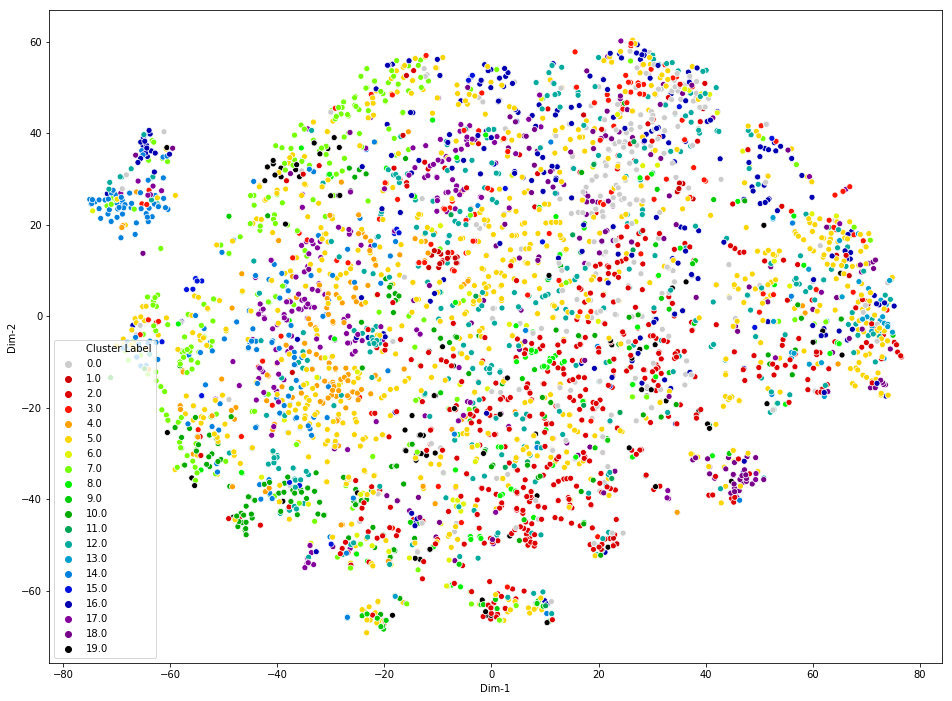

In [421]:
dfg = graph_cluster(tmatrix, label_df)

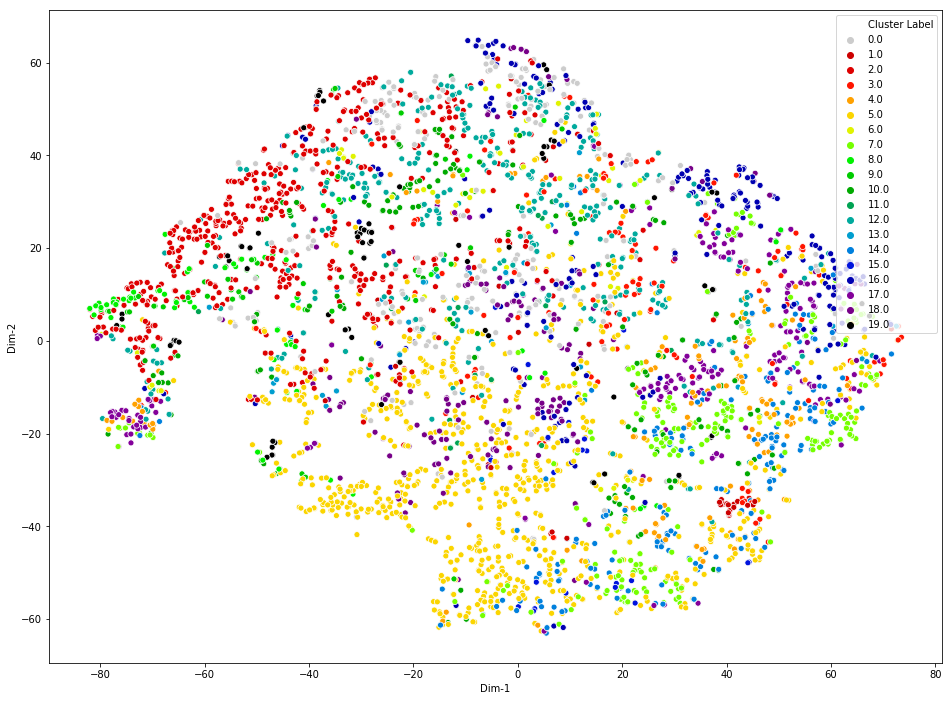

In [422]:
dfg = graph_cluster(wpt2v_array, label_df)